# ライブラリーのインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from spellchecker import SpellChecker
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [2]:
tweet = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
print(tweet.shape, test.shape)

(7613, 5) (3263, 4)


<AxesSubplot:xlabel='target', ylabel='count'>

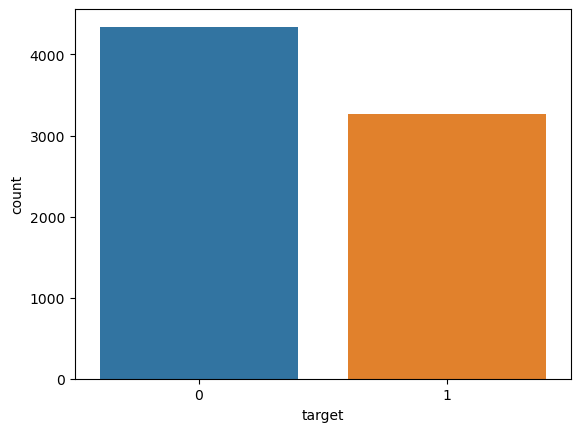

In [6]:
sns.countplot(x='target', data=tweet)

# データクリーニング

In [7]:
df = pd.concat([tweet, test])
df.shape

(10876, 5)

In [8]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

df['text'] = df['text'].apply(lambda x : remove_URL(x))

In [9]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text'] = df['text'].apply(lambda x : remove_html(x))

In [10]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [11]:
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

df['text'] = df['text'].apply(lambda x : remove_punct(x))

# コーパス(まとまった量のテキスト)の作成

In [12]:
def create_corpus(df):
    corpus=[]
    for tweet in df['text']:
        words = [word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus
    
corpus = create_corpus(df)

In [13]:
MAX_LEN = 50

# テキストコーパスをベクトル化、シーケンス型へ変換
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)

sequences = tokenizer_obj.texts_to_sequences(corpus)
word_index = tokenizer_obj.word_index

# シーケンスを同じ長さになるように詰める
tweet_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

#  GloVeに含まれている単語とベクトルを辞書にして整理する

In [14]:
embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

# 使用する単語とGloVeのベクトルを結ぶ

In [15]:
EMBEDDING_DIM = 100 #50, 100, 200, 300が選べる
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in word_index.items():
    emb_vector = embedding_dict.get(word)
    if emb_vector is not None:
        embedding_matrix[i] = emb_vector

# モデルの構築

In [16]:
embedding = Embedding(num_words, 100,
                      embeddings_initializer=Constant(embedding_matrix), #  すべて重みを定数で初期化
                      input_length=MAX_LEN,
                      trainable=False)

In [17]:
model = Sequential()

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           2034300   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


2022-12-13 18:01:41.035615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [20]:
X_train,X_val,y_train,y_val=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_val.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [21]:
history = model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_val,y_val),verbose=2)

Epoch 1/15
1618/1618 - 57s - loss: 0.6913 - accuracy: 0.5678 - val_loss: 0.6866 - val_accuracy: 0.5841 - 57s/epoch - 35ms/step
Epoch 2/15
1618/1618 - 54s - loss: 0.6190 - accuracy: 0.6636 - val_loss: 0.5370 - val_accuracy: 0.7574 - 54s/epoch - 33ms/step
Epoch 3/15
1618/1618 - 53s - loss: 0.5468 - accuracy: 0.7541 - val_loss: 0.5116 - val_accuracy: 0.7671 - 53s/epoch - 33ms/step
Epoch 4/15
1618/1618 - 53s - loss: 0.5315 - accuracy: 0.7555 - val_loss: 0.5009 - val_accuracy: 0.7706 - 53s/epoch - 33ms/step
Epoch 5/15
1618/1618 - 58s - loss: 0.5190 - accuracy: 0.7594 - val_loss: 0.4936 - val_accuracy: 0.7741 - 58s/epoch - 36ms/step
Epoch 6/15
1618/1618 - 58s - loss: 0.5075 - accuracy: 0.7718 - val_loss: 0.4887 - val_accuracy: 0.7758 - 58s/epoch - 36ms/step
Epoch 7/15
1618/1618 - 56s - loss: 0.4999 - accuracy: 0.7735 - val_loss: 0.4859 - val_accuracy: 0.7802 - 56s/epoch - 34ms/step
Epoch 8/15
1618/1618 - 54s - loss: 0.4966 - accuracy: 0.7769 - val_loss: 0.4820 - val_accuracy: 0.7793 - 54s/ep

# 提出

In [25]:
y_pred = model.predict(test)
y_pred = np.round(y_pred).astype(int).reshape(3263)

sample_submission = pd.read_csv('sample_submission.csv')

submission = pd.DataFrame({'id':sample_submission['id'].values.tolist(),'target':y_pred})
submission.to_csv('submisson.csv', index=False)

102/102 [==============================] - 0s 4ms/step


In [35]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,0
